In [1]:
import os 
import numpy as np
import tensorflow as tf

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## **Getting Started with Cityscapes**

### **Installation**

1. Unzip the archives to get datasets

In [ ]:
!unzip drive/MyDrive/dataset/leftImg8bit_trainvaltest.zip

In [ ]:
!unzip drive/MyDrive/dataset/gtFine_trainvaltest.zip

2. Move thoses datasets to folder `/datasets/CITYSCAPES_DATASET`

In [4]:
!mkdir datasets
!mkdir datasets/cityscapes

In [5]:
!mv left* datasets/cityscapes
!mv gtFine datasets/cityscapes

4. Clone the git repository containing the scripts provided by Cityscapes authors to handle the dataset



In [6]:
!git clone https://github.com/mcordts/cityscapesScripts.git

Cloning into 'cityscapesScripts'...
remote: Enumerating objects: 623, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 623 (delta 26), reused 29 (delta 18), pack-reused 574
Receiving objects: 100% (623/623), 832.57 KiB | 17.71 MiB/s, done.
Resolving deltas: 100% (338/338), done.


5. Compile the scripts

In [ ]:
!cd ./cityscapesScripts
!pip install cityscapesscripts

6. Set an environment variable `CITYSCAPES_DATASET` pointing to the folder containing the data. For processing of the scripts later.

In [8]:
os.environ['CITYSCAPES_DATASET'] = 'datasets/cityscapes'

7. To transform the .json semantic annotations into mask images (which will be stored in the same folder)

In [9]:
!csCreateTrainIdLabelImgs

Processing 5000 annotation files
Progress: 100.0 % 

### **Cityscapes Classes**

In [10]:
import cityscapesscripts.helpers.labels as cityscapes_labels

table_format = '| {0: >2} | {1: <20} | {2: >7} | {3: >15} | {4: <12} | {5: >5} |'

header = table_format.format('id', 'name', 'trainId', 'color', 'category', 'catId')
print(header)
print('_' * len(header))
for label in cityscapes_labels.labels:
  print(table_format.format(
      label.id, label.name, label.trainId, str(label.color), label.category, 
      label.categoryId))

| id | name                 | trainId |           color | category     | catId |
________________________________________________________________________________
|  0 | unlabeled            |     255 |       (0, 0, 0) | void         |     0 |
|  1 | ego vehicle          |     255 |       (0, 0, 0) | void         |     0 |
|  2 | rectification border |     255 |       (0, 0, 0) | void         |     0 |
|  3 | out of roi           |     255 |       (0, 0, 0) | void         |     0 |
|  4 | static               |     255 |       (0, 0, 0) | void         |     0 |
|  5 | dynamic              |     255 |    (111, 74, 0) | void         |     0 |
|  6 | ground               |     255 |     (81, 0, 81) | void         |     0 |
|  7 | road                 |       0 |  (128, 64, 128) | flat         |     1 |
|  8 | sidewalk             |       1 |  (244, 35, 232) | flat         |     1 |
|  9 | parking              |     255 | (250, 170, 160) | flat         |     1 |
| 10 | rail track           

As we can see, Cityscapes contains more than 30 classes. Each have their own ID, category (8 higher-level classes), color (to display the label maps), etc.

However, as we can see, several classes have the same `trainId`. We will completely ignore these classes in our experiments, keeping only those with `trainId > 0` and `trainId != 5`:


In [11]:
CITYSCAPES_IGNORE_VALUE = 255
CITYSCAPES_LABELS = [label for label in cityscapes_labels.labels
                     if 0 <= label.trainId < CITYSCAPES_IGNORE_VALUE]

In [12]:
table_format = '| {0: >7} | {1: <20} | {2: >15} |'
header = table_format.format('trainId', 'name', 'color')
print(header)
print('-' * len(header))
for label in CITYSCAPES_LABELS:
  print(table_format.format(label.trainId, label.name, str(label.color)))

| trainId | name                 |           color |
----------------------------------------------------
|       0 | road                 |  (128, 64, 128) |
|       1 | sidewalk             |  (244, 35, 232) |
|       2 | building             |    (70, 70, 70) |
|       3 | wall                 | (102, 102, 156) |
|       4 | fence                | (190, 153, 153) |
|       5 | pole                 | (153, 153, 153) |
|       6 | traffic light        |  (250, 170, 30) |
|       7 | traffic sign         |   (220, 220, 0) |
|       8 | vegetation           |  (107, 142, 35) |
|       9 | terrain              | (152, 251, 152) |
|      10 | sky                  |  (70, 130, 180) |
|      11 | person               |   (220, 20, 60) |
|      12 | rider                |     (255, 0, 0) |
|      13 | car                  |     (0, 0, 142) |
|      14 | truck                |      (0, 0, 70) |
|      15 | bus                  |    (0, 60, 100) |
|      16 | train                |    (0, 80, 

We are thus left with **19 classes**, which is already quite a challenging number for a task as complicated as pixel-level classification

## **First Glance**

We will now finally have a **look at the images** themselves, and their corresponding **label maps**

In [13]:
# Color list for each remaining classes
CITYSCAPES_COLORS = np.array([label.color for label in CITYSCAPES_LABELS])

In [14]:
# Dataset folder
CITYSCAPES_FOLDER = os.getenv('CITYSCAPES_DATASET', 
                              default=os.path.expanduser('/content/datasets/cityscapes'))

In [15]:
import glob

CITYSCAPES_INT_FILL = 6  # length of Cityscapes image IDs (e.g., "000001")
CITYSCAPES_FILE_TEMPLATE = os.path.join(
    '{root}', '{type}', '{split}', '{city}',
    '{city}_{seq:{filter}>{len_fill}}_{frame:{filter}>{len_fill}}_{type}{type2}{ext}')

def get_cityscapes_file_pairs(split='train', city='*', sequence='*',
                              frame='*', ext='.*', gt_type='labelTrainIds', 
                              type='leftImg8bit', root_folder=CITYSCAPES_FOLDER,
                              file_template=CITYSCAPES_FILE_TEMPLATE):
  """
  Fetch pairs of filenames for the Cityscapes dataset.
  :param split: Name of the split to return pairs from {'train', 'val', ...}
  :param city: Name of the city(ies)
  :param sequence: Name of the video sequence(s)
  :param frame: Name of the frame
  :param ext: File extension
  :param gt_type: Cityscapes GT type
  :param type: Cityscapes image type
  :param root_folder: Cityscapes root folder
  :param file_template: File template to be applied (default corresponds to
                        Cityscapes original format)
  :return: List of input files, List of corresponding GT files
  """

  input_file_template = file_template.format(
      root=root_folder, type=type, type2='', len_fill=1, filter='*',
      split=split, city=city, seq=sequence, frame=frame, ext=ext)
  input_files = glob.glob(input_file_template)

  gt_file_template = file_template.format(
      root=root_folder, type='gtFine', type2='_'+gt_type, len_fill=1, filter='*',
      split=split, city=city, seq=sequence, frame=frame, ext=ext)
  gt_files = glob.glob(gt_file_template)

  assert (len(input_files) == len(gt_files))

  return sorted(input_files), sorted(gt_files)

In [16]:
train_input_files, train_gt_files = get_cityscapes_file_pairs(
    split='train', type='leftImg8bit')
val_input_files, val_gt_files = get_cityscapes_file_pairs(
    split='val', type='leftImg8bit')
print('Cityscapes - Training Dataset: {} images ; {} GTs'.format(
    len(train_input_files), len(train_gt_files)))
print('Cityscapes - Validation Dataset: {} images ; {} GTs'.format(
    len(val_input_files), len(val_gt_files)))

Cityscapes - Training Dataset: 2975 images ; 2975 GTs
Cityscapes - Validation Dataset: 500 images ; 500 GTs


Now that we have access to all the data pairs, let us visualize some. For that purpose, we write another function to convert label maps (2D tensors containing the `trainID` value for each pixel) into color images we can more easily visualize:

In [17]:
import matplotlib.gridspec as gridspec

def plot_image_grid(images, titles=None, figure=None, grayscale=False, transpose=False):
    """
    Plot a grid of n x m images
    :param images:       Images in a n x m array
    :param titles:       (opt.) List of m titles for each image column
    :param figure:       (opt.) Pyplot figure (if None, will be created)
    :param grayscale:    (opt.) Flag to draw the images in grayscale
    :param transpose:    (opt.) Flag to transpose the grid
    :return:             Pyplot figure filled with the images
    """
    num_cols, num_rows = len(images), len(images[0])
    img_ratio = images[0][0].shape[1] / images[0][0].shape[0]

    if transpose:
        vert_grid_shape, hori_grid_shape = (1, num_rows), (num_cols, 1)
        figsize = (int(num_rows * 5 * img_ratio), num_cols * 5)
        wspace, hspace = 0.2, 0.
    else:
        vert_grid_shape, hori_grid_shape = (num_rows, 1), (1, num_cols)
        figsize = (int(num_cols * 5 * img_ratio), num_rows * 5)
        hspace, wspace = 0.2, 0.

    if figure is None:
        figure = plt.figure(figsize=figsize)
    imshow_params = {'cmap': plt.get_cmap('gray')} if grayscale else {}
    grid_spec = gridspec.GridSpec(*hori_grid_shape, wspace=0, hspace=0)

    for j in range(num_cols):
        grid_spec_j = gridspec.GridSpecFromSubplotSpec(
            *vert_grid_shape, subplot_spec=grid_spec[j], wspace=wspace, hspace=hspace)

        for i in range(num_rows):
            ax_img = figure.add_subplot(grid_spec_j[i])
            # ax_img.axis('off')
            ax_img.set_yticks([])
            ax_img.set_xticks([])
            if titles is not None:
                if transpose:
                    ax_img.set_ylabel(titles[j], fontsize=25)
                else:
                    ax_img.set_title(titles[j], fontsize=15)
            ax_img.imshow(images[j][i], **imshow_params)

    figure.tight_layout()
    return figure

In [18]:
def convert_labels_to_colors_numpy(label, one_hot=True, num_classes=len(CITYSCAPES_LABELS),
                                   color_array=CITYSCAPES_COLORS, ignore_value=CITYSCAPES_IGNORE_VALUE):
    """
    Convert label images into color ones for display (for numpy objects).
    :param label:           Label image (numpy array)
    :param one_hot:         Flag if the label image hasn't been one-hot yet and therefore should
    :param num_classes:     Number of classes (for one-hotting)
    :param color_array:     Array mapping labels to colors
    :param ignore_value:    Value of label to be ignored (for one-hotting)
    :return:                Color map
    """
    
    if one_hot:
        label_shape = label.shape
        label = label.reshape(-1)
        label[label == ignore_value] = num_classes
        label = np.eye(num_classes + 1, dtype=np.int32)[[label]]
        label = label[..., :num_classes]
    else:
        label_shape = label.shape[:-1]
        label = label.reshape(-1, label.shape[-1])

    colors = np.matmul(label, color_array)

    return colors.reshape(list(label_shape) + [colors.shape[1]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


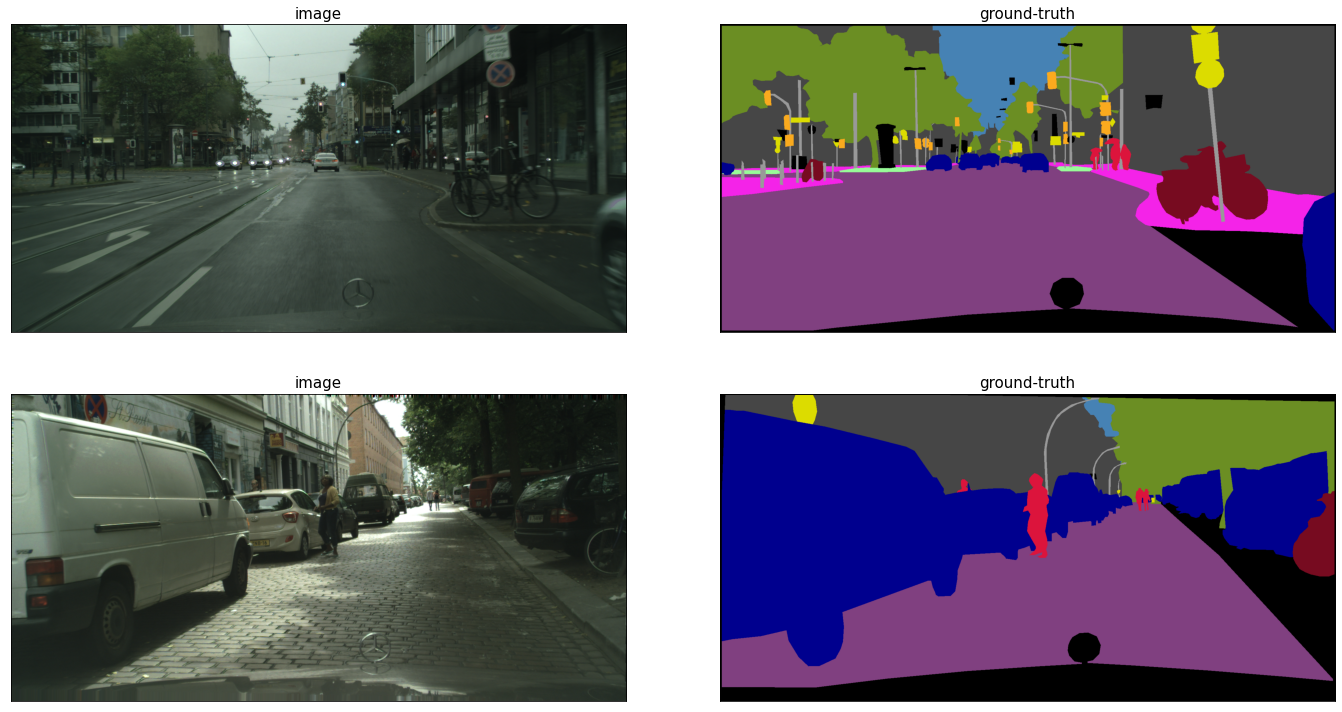

In [19]:
import skimage.io as io 
import matplotlib.pyplot as plt

num_show = 2
np.random.seed(seed)
random_ids = np.random.choice(len(train_input_files), size=num_show)

train_input_files_samples = [train_input_files[i] for i in random_ids]
train_gt_files_samples = [train_gt_files[i] for i in random_ids]

images_samples = [io.imread(file) for file in train_input_files_samples]
gt_samples = [io.imread(file) for file in train_gt_files_samples]
gt_colors = [convert_labels_to_colors_numpy(mask) for mask in gt_samples]
figure = plot_image_grid([images_samples, gt_colors], ["image", "ground-truth"])
figure.show()

## **Setiing Up the Input Pipeline**

We will now use the `tf.data` API to build an input pipeline, to serve the training/validation batches to our future models.


### **Image Parsing and Augmentation**

We first define some TF-based functions to parse the image and label files into proper tensors, then optionally to augment the data.


To simplify a bit the models later, we will change the ratio of the dataset images, making them square. In order to scale the predictions back to the original shape in post-processing, we will save the original ratio/shape:

In [20]:
CITYSCAPES_IMG_RATIO = int(images_samples[0].shape[1]) / int(images_samples[0].shape[0])
print('Cityscapes image shape = {} --> ratio = {} (to reshape squared images later'.format(
    images_samples[0].shape, CITYSCAPES_IMG_RATIO))

Cityscapes image shape = (1024, 2048, 3) --> ratio = 2.0 (to reshape squared images later


The following function (bases on the one already used in the previous notebook) parses the pairs of the filenames yielded by our data pipeline, into tensor

In [21]:
def parse_function(filenames, resize_to=[226, 226], augment=True):
  """
  Parse files into input/label image pair
  :param filenames: Dict containing the file(s) (filenames['image'], filenames['label'])
  :param resize_to: H x W Dimensions to resize the image and label to
  :param augment: Flag to augment the pair
  :return: Input tensor, Label tensor
  """

  img_filename, gt_filename = filenames['image'], filenames.get('label', None)

  # Reading the file and returning its content as bytes
  image_string = tf.io.read_file(img_filename)
  # Decoding into an image
  image_decoded = tf.io.decode_jpeg(image_string, channels=3)

  # Converting image to float
  image = tf.image.convert_image_dtype(image_decoded, tf.float32)

  # Resizing
  image = tf.image.resize(image, resize_to)

  if gt_filename is not None:
    # Same fo GT image
    gt_string = tf.io.read_file(gt_filename)
    gt_decoded = tf.io.decode_png(gt_string, channels=1)
    gt = tf.cast(gt_decoded, dtype=tf.int32)
    gt = tf.image.resize(gt, resize_to, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Opt. augmenting the image
    if augment:
      image, gt = _augmentation_fn(image, gt)
    return image, gt
  else:
    if augment:
      image = _augmentation_fn(image)
    return image

Optionally, the pipeline may also augment the data, applying various random transformations (random color/brightness changes, random horizontal flip, random cropping/scaling, etc.). However, unlike the previous pipelines, we have to be careful to apply some transformations both to the input image and to the target label map. Indeed, if we flip or crop the image, the same should be done to the label map, so the two stay aligned.

In [22]:
def _augmentation_fn(image, gt_image=None):
  """
  Apply random transformations to augment the training images
  :param image: Image
  :return: Augmented image
  """

  original_shape = tf.shape(image)[-3:-1]
  num_image_channels = tf.shape(image)[-1]

  # If we decide to randomly flip or resize/crop the image, the same should be 
  # applied to the label one so they still match. Therefore, to simplify the 
  # procedure, we stack the two images together along the channel axis, before
  # these random operations
  if gt_image is None:
    stacked_images = image
    num_stacked_channels = num_image_channels
  else:
    stacked_images = tf.concat([image, tf.cast(gt_image, dtype=image.dtype)], 
                               axis=-1)
    num_stacked_channels = tf.shape(stacked_images)[-1]

  # Randomly applied horizontal flip
  stacked_images = tf.image.random_flip_left_right(stacked_images)

  # Random cropping
  random_scale_factor = tf.random.uniform([], minval=.8, maxval=1., dtype=tf.float32)
  crop_shape = tf.cast(tf.cast(original_shape, tf.float32) * random_scale_factor,
                       tf.int32)
  if len(stacked_images.shape) == 3:  # single image
    crop_shape = tf.concat([crop_shape, [num_stacked_channels]], axis=0)
  else:
    batch_size = tf.shape(stacked_images)[0]
    crop_shape = tf.concat([[batch_size], crop_shape, [num_stacked_channels]], axis=0)
  stacked_images = tf.image.random_crop(stacked_images, crop_shape)

  # The remaining transformations should be applied either differently to the input
  # and GT images (nearest-neighbor resizing for the label image VS interpolated
  # resizing for the image), or only to the input image, not the GT one (color changes,
  # etc.). Therefore, we split them back
  image = stacked_images[..., :num_image_channels]

  # Resizing back to expected dimensions
  image = tf.image.resize(image, original_shape)

  # Random B/S changes
  image = tf.image.random_brightness(image, max_delta=0.15)
  image = tf.image.random_saturation(image, lower=0.5, upper=1.75)
  image = tf.clip_by_value(image, 0.0, 1.0)  # keeping pixel value in check

  if gt_image is not None:
    gt_image = tf.cast(stacked_images[..., num_image_channels:], dtype=gt_image.dtype)
    gt_image = tf.image.resize(gt_image, original_shape, 
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return image, gt_image
  else:
    return image

We can finally put everything together, and wrap them into an input function we could later simply call to instantiate the data pipeline:

In [23]:
import functools

def segmentation_input_fn(image_files, gt_files=None, resize_to=[256, 256], 
                          shuffle=False, batch_size=32, num_epochs=None,
                          augment=False, seed=None):
  """
  Set up an input data pipeline for semantic segmentation applications
  :param image_files: List of input image files
  :param gt_files: (opt.) List of corresponding label image files
  :param resize_to: H x W Dimensions to resize the image and label to
  :param shuffle: Flag to shuffle the dataset
  :param batch_size: Batch size
  :param num_epochs: Number of epochs the dataset would be iterated over
  :param augment: Flag to augment the pairs
  :param seed: (opt.) Seed
  :return: tf.data.Dataset
  """

  # Converting to TF dataset
  image_files = tf.constant(image_files)
  data_dict = { 'image': image_files }
  if gt_files is not None:
    gt_files = tf.constant(gt_files)
    data_dict['label'] = gt_files
  dataset = tf.data.Dataset.from_tensor_slices(data_dict)

  if shuffle:
    dataset = dataset.shuffle(buffer_size=1000, seed=seed)
  dataset = dataset.prefetch(1)

  # Batching + adding parsing operation
  parse_fn = functools.partial(parse_function, resize_to=resize_to, augment=augment)
  dataset = dataset.map(parse_fn, num_parallel_calls=4)
  dataset = dataset.batch(batch_size)

  dataset = dataset.repeat(num_epochs)
  
  return dataset


def cityscapes_input_fn(split='train', root_folder=CITYSCAPES_FOLDER, resize_to=[256, 256],
                        shuffle=False, batch_size=32, num_epochs=None, augment=False,
                        seed=None, blurred=False):
  """
  Set up an input data pipeline for semantic segmentation applications on 
  Cityscapes dataset
  :param split: Split name {'train', 'val', 'test'}
  :param root_folder: Cityscapes root folder
  :param resize_to: H x W Dimensions to resize the image and label to
  :param shuffle: Flag to shuffle the dataset
  :param batch_size: Batch size
  :param num_epochs: Number of epochs the dataset would be iterated over
  :param augment: Flag to augment the pairs
  :param seed: (opt.) Seed
  :param blurred: Flag to use images with faces and immatriculation plates blurred
                    (for display)
  :return: tf.data.Dataset
  """

  type = 'leftImg8bit_blurred' if blurred else 'leftImg8bit'
  input_files, gt_files = get_cityscapes_file_pairs(split=split, root_folder=root_folder,
                                                    type=type, gt_type='labelTrainIds')
  
  return segmentation_input_fn(input_files, gt_files, resize_to, shuffle, batch_size,
                               num_epochs, augment, seed)

Example how these methods can be later called:

In [25]:
batch_size = 16
num_epochs = 50
image_size = [512, 512]

train_dataset = segmentation_input_fn(
    train_input_files_samples, train_gt_files_samples, resize_to=image_size,
    batch_size=batch_size, shuffle=True, num_epochs=num_epochs, augment=True)

val_dataset = segmentation_input_fn(
    val_input_files, val_gt_files, resize_to=image_size, batch_size=batch_size,
    shuffle=False, num_epochs=None, augment=False)

### **Visualization Tools**

As additional helpers for later, we define some methods to post-process results, e.g., for visualization:

In [26]:
# TF constant corresponding to our color list:
CITYSCAPES_COLORS_TF = tf.constant(CITYSCAPES_COLORS, dtype=tf.int32)

def change_ratio(image=None, pred=None, gt=None, ratio=CITYSCAPES_IMG_RATIO):
    """
    Resze the images to the corresponding ratio.
    :param image:   (opt) Input image
    :param pred:    (opt) Predicted label image
    :param gt:      (opt) Target image
    :param ratio:   Ratio
    :return:        3 resized images
    """
    valid_input = image if image is not None else pred if pred is not None else gt
    current_size = tf.shape(valid_input)[-3:-1]
    width_with_ratio = tf.cast(tf.cast(current_size[1], tf.float32) * ratio, tf.int32)
    size_with_ratio = tf.stack([current_size[0], width_with_ratio], axis=0)
    if image is not None:
        image = tf.image.resize(image, size_with_ratio)
    if pred is not None:
        pred = tf.image.resize(pred, size_with_ratio, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    if gt is not None:
        gt = tf.image.resize(gt, size_with_ratio, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, pred, gt


def convert_label_to_colors(label, one_hot=True, num_classes=len(CITYSCAPES_LABELS),
                            color_tensor=CITYSCAPES_COLORS_TF):
    """
    Convert label images into color ones for display (for Tensors).
    :param label:           Label image (Tensor)
    :param one_hot:         Flag if the label image hasn't been one-hot yet and therefore should
    :param num_classes:     Number of classes (for one-hotting)
    :param color_tensor:    Tensor mapping labels to colors
    :return:                Color map
    """

    label_shape = tf.shape(label)
    color_channels = tf.shape(color_tensor)[-1]

    if one_hot:
        label = tf.one_hot(label, num_classes)
    else:
        label_shape = label_shape[:-1]

    label = tf.reshape(tf.cast(label, tf.int32), (-1, num_classes))
    colors = tf.matmul(label, color_tensor)

    return tf.reshape(colors, tf.concat([label_shape, [color_channels]], axis=0))


def postprocess_to_show(image=None, pred=None, gt=None, one_hot=True, ratio=CITYSCAPES_IMG_RATIO):
    """
    Post-process the training results of a segmentation model (as Tensors), for display.
    :param image:       (opt.) Input image tensor
    :param pred:        (opt.) Predicted label map tensor
    :param gt:          (opt.) Target label map tensor
    :param one_hot:     Flag if the predicted label image hasn't been one-hot yet and therefore should
    :param ratio:       Original image ratio
    :return:            Processed image tensor(s)
    """
    out = []
    image_show, pred_show, gt_show = change_ratio(image, pred, gt,
                                                  ratio)
    if image is not None:
        out.append(image_show)

    if pred is not None:
        if one_hot:
            pred_show = tf.squeeze(pred_show, -1)  # removing unnecessary channel dimension
        pred_show = convert_label_to_colors(pred_show, one_hot=one_hot)
        out.append(pred_show)

    if gt is not None:
        gt_show = tf.squeeze(gt_show, -1)  # removing unnecessary channel dimension
        gt_show = convert_label_to_colors(gt_show)
        out.append(gt_show)

    return out if len(out) > 1 else out[0]

Let directly apply these methods to the visualization of some augmented training images:

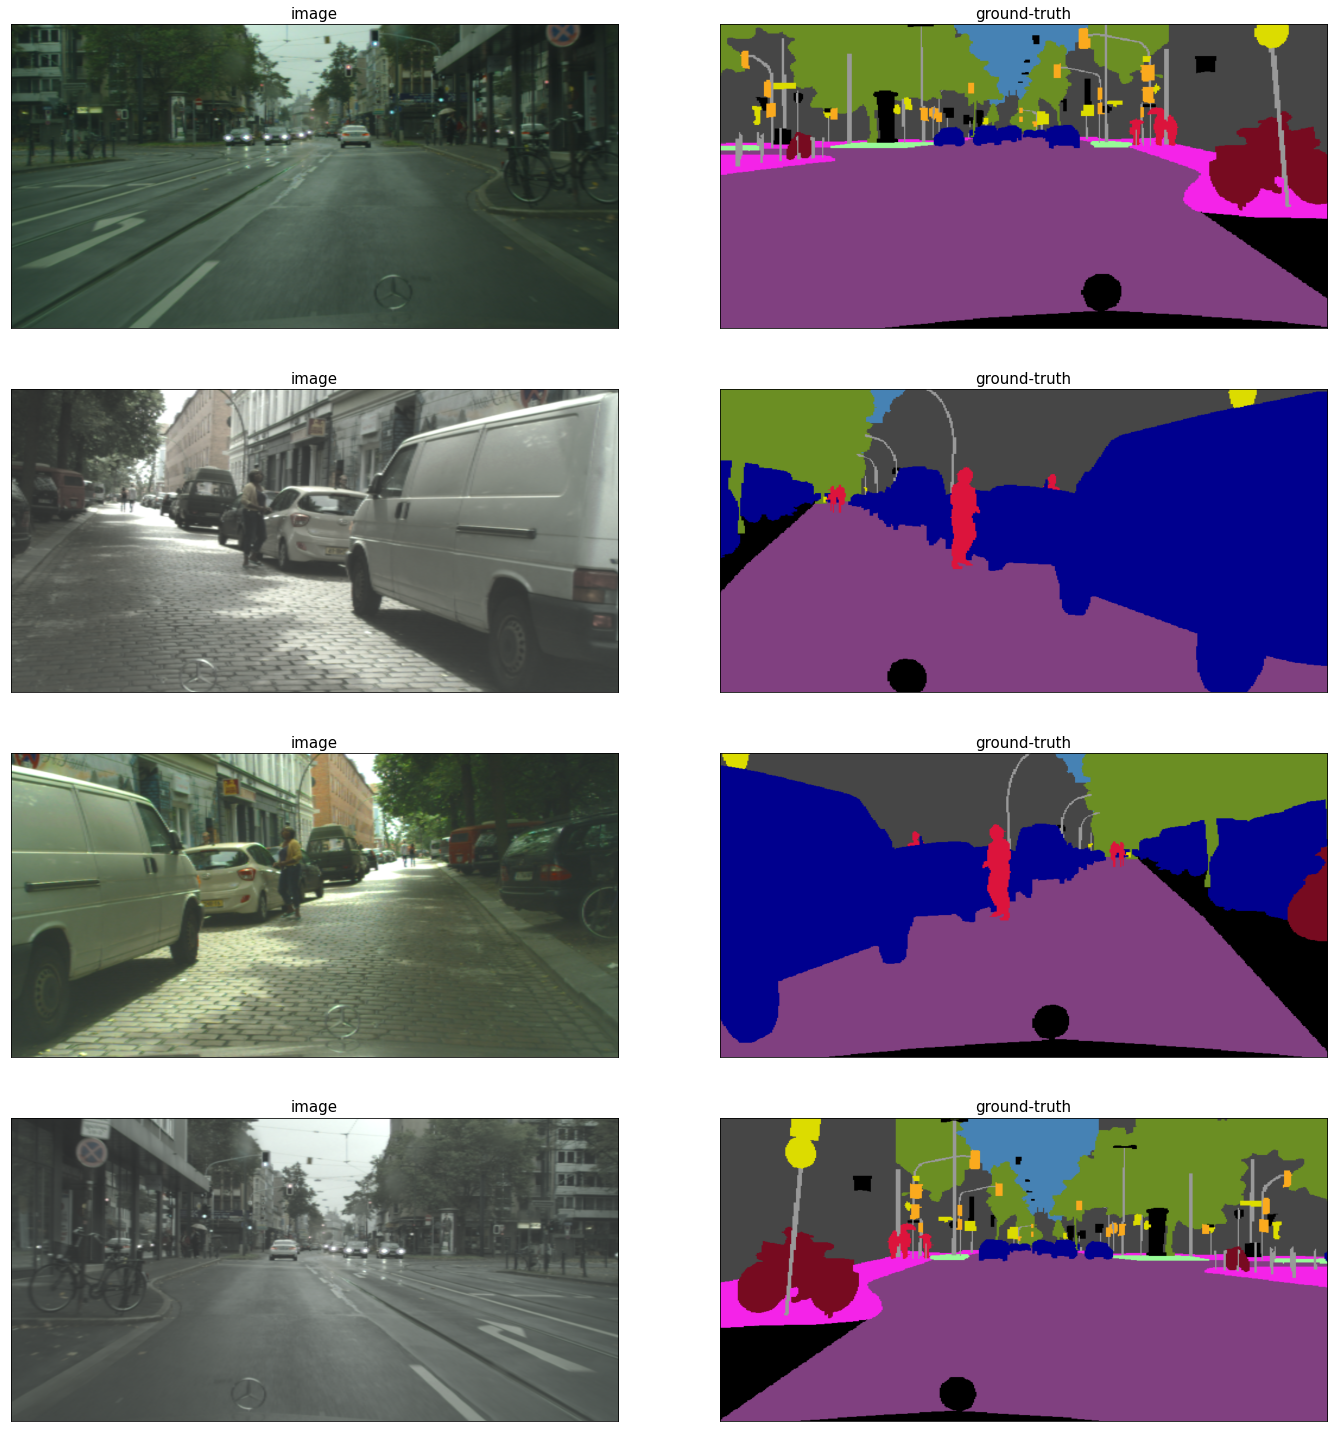

In [27]:
train_dataset_iter = train_dataset.__iter__()
train_images1, train_labels1 = next(train_dataset_iter)
train_images2, train_labels2 = next(train_dataset_iter)

train_images = np.concatenate((train_images1[:num_show], train_images2[:num_show]), axis=0)
train_labels = np.concatenate((train_labels1[:num_show], train_labels2[:num_show]), axis=0)

image_show, gt_show = postprocess_to_show(train_images, train_labels)

figure = plot_image_grid([image_show, gt_show],
                         ['image', 'ground-truth'])
figure.show()